## 1、 PyTorch实现LSTM

内容将以2015年上海轨道交通中山公园站时间粒度为15min的客流进站数据为例，利用PyTorch搭建LSTM网络，实现对进站客流数据的预测。

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable

使用pandas包里的read_csv()函数读取中山公园站连续5周的csv格式的客流数据：

In [2]:
data_csv = pd.read_csv("./zhongshanpark.csv",encoding = 'gb2312')
data_csv.head()

,中山公园
0,12
1,46
2,80
3,77
4,159


使用matplotlib包里的pyplot.plot()函数来可视化输入的数据：

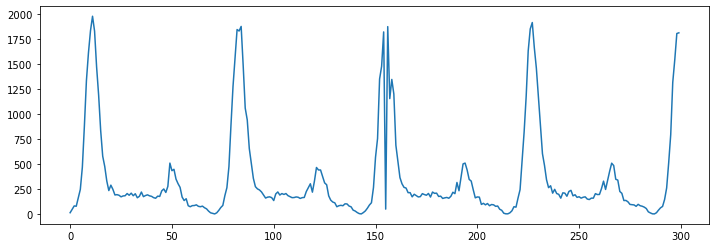

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(data_csv[0:300])

从输出的客流图可以看出，中山公园站从早到晚地铁站的客流变化趋势是有规律的，并且能够明显的观察到一天中的客流早晚高峰情况。接着把处理后的数据输入到自己训练的LSTM模型里面，希望通过RNN中LSTM模型来预测客流。

下面开始数据预处理，去掉无效数据，并且将数据归一化到[0, 1]之间，数据的归一化在深度学习中可以提升模型的收敛速度和精度。
使用dropna()函数去掉数据中的空值所在的行和列，使用astype变化数组类型，并且手动将数据集中的数据值大小固定到[0, 1]：

In [4]:
data_csv = data_csv.dropna()
dataset = data_csv.values 
dataset = dataset.astype('float32') # 改变dataset类型

min_value = np.min(dataset) #最小值
max_value = np.max(dataset) #最大值

cs = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / cs, dataset)) #标准化固定【0,1】

创建训练和测试LSTM模型的数据集，是通过前面测试的15min时间粒度的客流量来预测当前时间粒度的客流量，我们令前2个时间粒度的客流数据是输入，对应代码中的step=2，把当前时间粒度的客流数据作为输出，划分数据集为训练集（training set）和测试集（testing set），通过测试集得到的效果来评估模型的性能：

In [5]:
def create_dataset(dataset, step=8):
    dataX, dataY = [], []
    for i in range(len(dataset) - step):
        a = dataset[i:(i + step)]
        dataX.append(a)
        dataY.append(dataset[i + step])
    return np.array(dataX), np.array(dataY)

定义好输入和输出：

In [6]:
data_X, data_Y = create_dataset(dataset)

划分训练集和测试集，70%的数据作为训练集，30%的数据作为测试集

In [7]:
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

改变数据维度，对一个样本而言，序列只有一个，所以batch_size=1，我们根据前两个时间粒度预测第三个，所以feature=2

In [8]:
train_X = train_X.reshape(-1, 1, 8)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 8)
test_Y = test_Y.reshape(-1, 1, 1)

train1 = torch.from_numpy(train_X)
train2 = torch.from_numpy(train_Y)
test1 = torch.from_numpy(test_X)
test2 = torch.from_numpy(test_Y)

定义模型并将输出值回归到流量预测的最终结果，模型的第一部分是一个两层的RNN

In [12]:
# 定义模型
class LSTM_linear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(LSTM_linear, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers) # RNN
        self.linear = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.lstm(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.linear(x)
        x = x.view(s, b, -1)
        return x

输入维度是8，隐藏层维度为78，其中隐藏层维度可以任意指定，使用均方损失函数

In [13]:
net = LSTM_linear(8, 78)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

开始训练模型，这里我们训练200个epoch，每5次输出一次训练结果，即损失值，希望其经过训练可以下降，以满足我们的需求

In [21]:
# 开始训练（cpu版）
for e in range(200):
    out = net(train1)
    loss = criterion(out, train2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 5 == 0: 
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 5, Loss: 0.00101
Epoch: 10, Loss: 0.00099
Epoch: 15, Loss: 0.00099
Epoch: 20, Loss: 0.00099
Epoch: 25, Loss: 0.00098
Epoch: 30, Loss: 0.00099
Epoch: 35, Loss: 0.00100
Epoch: 40, Loss: 0.00098
Epoch: 45, Loss: 0.00097
Epoch: 50, Loss: 0.00097
Epoch: 55, Loss: 0.00097
Epoch: 60, Loss: 0.00097
Epoch: 65, Loss: 0.00102
Epoch: 70, Loss: 0.00096
Epoch: 75, Loss: 0.00096
Epoch: 80, Loss: 0.00095
Epoch: 85, Loss: 0.00095
Epoch: 90, Loss: 0.00094
Epoch: 95, Loss: 0.00094
Epoch: 100, Loss: 0.00093
Epoch: 105, Loss: 0.00094
Epoch: 110, Loss: 0.00094
Epoch: 115, Loss: 0.00094
Epoch: 120, Loss: 0.00117
Epoch: 125, Loss: 0.00095
Epoch: 130, Loss: 0.00096
Epoch: 135, Loss: 0.00093
Epoch: 140, Loss: 0.00091
Epoch: 145, Loss: 0.00089
Epoch: 150, Loss: 0.00089
Epoch: 155, Loss: 0.00088
Epoch: 160, Loss: 0.00088
Epoch: 165, Loss: 0.00103
Epoch: 170, Loss: 0.00095
Epoch: 175, Loss: 0.00093
Epoch: 180, Loss: 0.00088
Epoch: 185, Loss: 0.00089
Epoch: 190, Loss: 0.00087
Epoch: 195, Loss: 0.00085
Epoch:

通过训练过程中输出的Loss值可以看到，损失值在逐渐下降，在第200个epoch的时候达到0.001，可以说明模型训练还是比较有效果的。训练完成后，转换成测试模式（Testing mode），开始预测客流并且输出上海地铁客流预测结果。

In [23]:
# 预测并进行反归一化
net = net.eval() 
data_X = data_X.reshape(-1,1,2)
data_X = torch.Tensor(data_X)
pred_test = net(test1)
pred_test = pred_test.view(-1).data.numpy()*(max_value-min_value) + min_value
test2 = test2.view(-1).data.numpy()*(max_value-min_value) + min_value

将实际结果和预测结果用matplotlib包画图输出，其中真实数据用蓝色表示，预测的结果用橙色表示

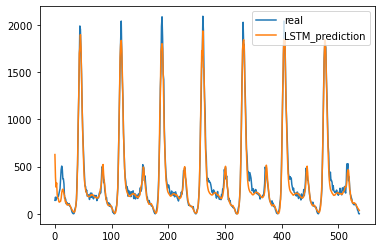

In [24]:
# 画出实际结果和预测的结果
plt.plot(test2, label='real')
plt.plot(pred_test,label='LSTM_prediction')
plt.legend(loc='best')

   通过上图可以看到，训练后的LSTM模型预测的客流数据确实能够比较准确的拟合真实客流数据，说明LSTM模型的时间序列预测能力是值得采纳的，但是其在小波动区间内仍存在一些粗略估计与误差，难以捕捉其局部特征，于是我们进而采取下一种模型。